# Distinguishing r/Seattle and r/SeattleWA

## Problem Statement

#### Background
*Reddit* is a forum like website that is partitioned into many communities called *subreddits*. These subreddits, often prefixed with 'r/', provide a space for people all over the world to interact with one another and share things related to the specific subreddit. Some examples of subreddits or r/explainlikeimfive, r/cooking, and r/SanFrancisco.
 
Since anyone can create a subreddit, many subreddits exist that appear to serve the same purpose on the surface. Usually these subreddits will still have their own differences that distinguish them from one another and justify their existence.

For example, there are several subreddits related to the city of Seattle: r/Seattle and r/SeattleWA. Someone who has not explored these subreddits very thoroughly may have a question to ask about Seattle and not know which subreddit would be the most fitting to post in.

#### Problem Statement
In this project we:
- explore the text data from posts on r/Seattle and r/SeattleWA
- try to identify notable ways in how these two subreddits differ
- and build classification models to try and predict if a post is more likely to come from r/Seattle or r/SeattleWA

Since r/Seattle and r/SeattleWA are likely to have very similar users and posts (there are certainly people who participate in both subreddits), it will be challenging to build a model that can perform strong predictions. We will deem our model successful if it can correctly classify which subreddit a post belongs to more than 60% of the time.

---

## Imports and Functions

In [2]:
# for pulling data and slowing request rate
import requests
import time

# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# text imports
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# visualization import
import plotly.express as px

In [4]:
def scrape_subreddit(subreddit):
    '''
    Given subreddit's name, request the most recent 2,250
    posts from the given subreddit.
    
    Combines the data into a csv file.
    '''
    
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {'subreddit': subreddit,
              'size': 250,
              'is_self': True,
              'selftext:not': '[removed]'}
    
    # assigns post data to variable 'posts'
    data = requests.get(url, params).json()
    posts = data['data']
    
    # adds the earliest post time to the 'before' API parameter
    # next request will collect posts before this time
    params['before'] = posts[-1]['created_utc']
    
    time.sleep(30)
    
    while len(posts) < 2_250:
        # collects next batch of posts data as 'next_posts'
        next_data = requests.get(url, params).json()
        next_posts = next_data['data']
        
        # concatenate posts data to 'posts'
        posts += next_posts
        
        # update API parameters to so the following 250 posts
        # will be requested in the next iteration of the loop
        earliest_post_time = next_posts[-1]['created_utc']
        params['before'] = earliest_post_time
        
        # delay next request and not spam the API
        time.sleep(30)
        
    posts_df = pd.DataFrame(posts)
    posts_df.to_csv(f'datasets/{subreddit}.csv', index = False)
    

def text_cleaning(text):
    '''
    Cleans text by removing [bracketed statements], urls, emails,
    some special characters (parentheses and stars), and some common html phrases.
    
    Returns the cleaned text
    '''
    
    # remove new lines
    text = re.sub('\n', ' ', text)
    
    # remove parentheses and asterisks
    text = re.sub("[\(\)\*]", '', text)
    
    # remove urls and do not include closing bracket ]
    text = re.sub('http\S+|www\.\S+', '', text)
    
    # remove email accounts
    text = re.sub('\S+@\S+', '', text)
    
    # remove bracketed strings
    text = re.sub('\[(\w|\s)*\]', '', text)
    
    # remove any leftover brackets
    text = re.sub('[\[\]]', '', text)
    
    # replace parentheses with spaces
    text = re.sub("/", ' ', text)
    
    # remove some common html phrases
    text = re.sub('&(gt|lt);', '', text)
    text = re.sub('&?amp;', '', text)
    text = re.sub('&?#x200b;?', '', text)
    text = re.sub('&?#x200B;?', '', text) 
    
    # replace whitespace with single space
    text = re.sub('\s+', ' ', text)
    
    # punctuation will be dropped after collecting sentiment
    # , ; : . ! ?
        
    return text


# although stop_drop_and_stem is a cooler name
# it would be slightly less clear :(
def drop_stop_and_stem(text):
    '''
    Takes a string, drops the stop words,
    and stems the remaining words with PorterStemmer.
    
    Returns the stemmed, non-stopwords
    '''
    
    pstem = PorterStemmer()
    
    #stem non-stopwords and put into a list
    stemmed_list = [pstem.stem(word) for word in text.split()
                    if word not in stopwords.words('english')]
    
    # return words separated by a space
    return ' '.join(stemmed_list)


def create_sentiment(df):
    '''
    Using Vader, collects sentiment from a DataFrame's "text" column.
    Creates three new columns titled "sent_pos", "sent_neg", and "sent_comp" from the 
    positive, negative, and compound sentiment scores.
    
    Returns the DataFrame with additional columns "sent_pos", "sent_neg", and "sent_comp".
    '''
    
    sent = SentimentIntensityAnalyzer()
    
    df['sent_pos'] = df['text'].apply(lambda x: sent.polarity_scores(x)['pos'])
    df['sent_neg'] = df['text'].apply(lambda x: sent.polarity_scores(x)['neg'])
    df['sent_compound'] = df['text'].apply(lambda x: sent.polarity_scores(x)['compound'])
    

def sample_three(series):
    '''
    Prints three random entries from a given series.
    '''
    for entry in series.sample(3):
        print(entry)
        print('----------\n')

---

## Collecting the Data

The code cell below uses the function `scrape_subreddit` to collect data on more than 2,000 posts from each subreddit r/Seattle and r/SeattleWA using [pushshift API](https://github.com/pushshift/api). The cell is commented out so that the results are consistent based on originally scraped datasets.

In [5]:
# collect more than 2,250 posts from /r/Seattle and /r/SeattleWA subreddits
# commented out because the data has already been collected

#scrape_subreddit('Seattle')
#scrape_subreddit('SeattleWA')

---

## Cleaning
#### First Impressions

Let us read in the data and get a sense of what the data looks like.

In [6]:
sea = pd.read_csv('datasets/Seattle.csv')
sea_wa = pd.read_csv('datasets/SeattleWA.csv')

In [7]:
sea.head(5)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,thumbnail_width,post_hint,preview,collections,author_flair_template_id,author_cakeday,distinguished,call_to_action,category,removed_by_category
0,[],False,Remarkable-Salt610,NaN,[],NaN,text,t2_ni0lq3vz,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,westrox11,NaN,[],NaN,text,t2_12a2u1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Soggy_Sneakers87,NaN,[],NaN,text,t2_a0vuvfra,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,LittleShallot,NaN,[],NaN,text,t2_13biud,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Chuckforpresident,NaN,[],NaN,text,t2_3xq1mh9j,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
sea.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_is_blocked',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_created_from_ads_ui', 'is_crosspostable', 'is_meta',
       'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable',
       'is_self', 'is_video', 'link_flair_background_color',
       'link_flair_richtext', 'link_flair_text_color', 'link_flair_type',
       'locked', 'media_only', 'no_follow', 'num_comments', 'num_crossposts',
       'over_18', 'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'total_awards_rece

Most of the data is filled with missing and most of the columns seem irrelevant to our goals. The `subreddit`, `title`, and `selftext` columns are our main interest since we want to distinguish the two subreddits based on the text content of each post.

Beyond this, `author` and `created_utc` may be relevant so let us keep these columns too.

In [9]:
# columns of interest
init_cols = ['subreddit', 'author', 'created_utc', 'title', 'selftext']

sea = sea[init_cols].copy()
sea_wa = sea_wa[init_cols].copy()

Let us see if there are any blatant things to clean in the data.

In [10]:
sea.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       0
dtype: int64

In [11]:
sea_wa.isnull().sum()

subreddit      0
author         0
created_utc    0
title          0
selftext       3
dtype: int64

In [12]:
print(sea.shape)
print(sea_wa.shape)

(2499, 5)
(2499, 5)


There should not be any harm in removing three entries with missing selftext data out of nearly 2,500 posts.

In [13]:
sea_wa.dropna(inplace = True)

#### Feature Engineering: Combined Text, Sentiment, and Word Count

One thing we will want to collect is the sentiment and word count of each post in case there are any general differences here between the two subreddits.

Before we do this, we can make our lives a little easier by concatenating the `title` and `selftext` data into a single column.

In [14]:
# create a new column from joining title text and selftext
sea['text'] = sea['title'] + ' ' + sea['selftext']
sea_wa['text'] = sea_wa['title'] + ' ' + sea_wa['selftext']

# drop former text columns
sea.drop(columns = ['title', 'selftext'], inplace = True)
sea_wa.drop(columns = ['title', 'selftext'], inplace = True)

We will also need to clean our text data before we collect the sentiment and word counts. This will hopefully make the resulting values more meaningful. Below we use our `text_cleaning` function to do basic cleaning like remove urls, select special characters, and bracketed text.

In [15]:
# remove urls and emails, special characters ()/*, and [bracketed strings]
sea['text'] = sea['text'].apply(text_cleaning)
sea_wa['text'] = sea_wa['text'].apply(text_cleaning)

Finally we use `vader` from `nltk` to collect the sentiment. Afterwards we drop the stopwords and stem. We collect sentiment first because `vader` may have trouble performing sentiment analysis on stemmed text.

In [16]:
# in place methods that generate positive and negative sentiment scores
# for the given dataframes
create_sentiment(sea)
create_sentiment(sea_wa)

In [17]:
# drop some leftover punctuation - some of which was necessary for sentiment analysis
sea['text'] = sea['text'].apply(lambda text: re.sub('[,;\.!\?]', '', text))
sea_wa['text'] = sea_wa['text'].apply(lambda text: re.sub('[,;\.!\?]', '', text))

In [18]:
# count number of words by splitting text across white space and recording list length
sea['word_count'] = sea['text'].str.split().str.len()
sea_wa['word_count'] = sea_wa['text'].str.split().str.len()

In [19]:
#remove stopwords and stem the result
sea['text'] = sea['text'].apply(drop_stop_and_stem)
sea_wa['text'] = sea_wa['text'].apply(drop_stop_and_stem)

As a sanity check, let us see if the head of our DataFrames match our general expectations.

In [20]:
sea.head(3)

,subreddit,author,created_utc,text,sent_pos,sent_neg,sent_compound,word_count
0,Seattle,Remarkable-Salt610,1664407377,special educ seattl surround area i’ll reloc s...,0.111,0.000,0.8406,94
1,Seattle,westrox11,1664403922,best lyche martini seattl i’m hunt best lyche ...,0.374,0.000,0.9178,23
2,Seattle,Soggy_Sneakers87,1664402515,save life hi i learn cpr first aid class there...,0.211,0.014,0.9756,118


In [21]:
sea_wa.head(3)

,subreddit,author,created_utc,text,sent_pos,sent_neg,sent_compound,word_count
0,SeattleWA,Sinkholediaries,1664416603,archspir fan i'm ladi obsess i need friend lik...,0.206,0.284,-0.4939,31
1,SeattleWA,prf_q,1664406559,is overseed season yet those maintain lawn: ar...,0.069,0.000,0.3485,35
2,SeattleWA,eatmoremeatnow,1664404071,showbox box offic ha anybodi recent bought tic...,0.034,0.058,-0.3270,55


#### Cleaning

We performed a lot of text cleaning, but there may be some posts that need to be removed on the whole due to having duplicate posts or being outliers.

Below we see the number of duplicate posts in each subreddit and what they look like in r/SeattleWA.

In [22]:
print(f"Number of duplicates posts in r/Seattle: {sea[sea['text'].duplicated()].sort_values(by = 'author').shape[0]}")
print(f"Number of duplicates posts in r/SeattleWA: {sea_wa[sea_wa['text'].duplicated()].sort_values(by = 'author').shape[0]}")
sea_wa[sea_wa['text'].duplicated()].sort_values(by = 'author').head(10)

Number of duplicates posts in r/Seattle: 7
Number of duplicates posts in r/SeattleWA: 40


,subreddit,author,created_utc,text,sent_pos,sent_neg,sent_compound,word_count
407,SeattleWA,AceItAcademy,1660688425,ace it academi - a newli open tutor servic bea...,0.025,0.0,0.3802,110
97,SeattleWA,AutoModerator,1663238408,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112
2328,SeattleWA,AutoModerator,1646912409,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112
2197,SeattleWA,AutoModerator,1647513608,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112
2119,SeattleWA,AutoModerator,1648118409,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112
2024,SeattleWA,AutoModerator,1648723209,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112
1944,SeattleWA,AutoModerator,1649328010,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112
1887,SeattleWA,AutoModerator,1649932809,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112
1798,SeattleWA,AutoModerator,1650537609,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112
1716,SeattleWA,AutoModerator,1651142410,seattl reddit commun open chat welcom daili lo...,0.084,0.0,0.8388,112


In [23]:
# drop duplicate entries
sea.drop_duplicates('text', inplace = True)
sea_wa.drop_duplicates('text', inplace = True)

Next let us examine the distributions and see if there are any outliers.

In [24]:
sea.describe()

,created_utc,sent_pos,sent_neg,sent_compound,word_count
count,2.492000e+03,2492.000000,2492.000000,2492.000000,2492.000000
mean,1.661454e+09,0.122780,0.047807,0.395880,93.412119
std,1.692212e+06,0.087505,0.060178,0.589711,127.173531
min,1.658632e+09,0.000000,0.000000,-0.999400,0.000000
25%,1.659980e+09,0.060000,0.000000,0.000000,39.000000
50%,1.661382e+09,0.113000,0.030000,0.636450,62.000000
75%,1.663022e+09,0.177000,0.075000,0.879525,104.250000
max,1.664407e+09,0.586000,0.462000,0.999800,2088.000000


In [25]:
sea_wa.describe()

,created_utc,sent_pos,sent_neg,sent_compound,word_count
count,2.456000e+03,2456.000000,2456.000000,2456.000000,2456.000000
mean,1.654616e+09,0.119180,0.052660,0.337581,81.930782
std,5.306147e+06,0.093221,0.071854,0.594802,88.568724
min,1.646007e+09,0.000000,0.000000,-0.997900,2.000000
25%,1.650032e+09,0.050000,0.000000,0.000000,33.000000
50%,1.654512e+09,0.108000,0.029000,0.536000,56.000000
75%,1.659459e+09,0.173250,0.081000,0.847125,98.000000
max,1.664417e+09,0.692000,0.730000,0.999500,1078.000000


From the summary statistics above we see that r/SeattleWA has a much higher maximum negative sentiment than r/Seattle and slightly higher maximum positive sentiment. Besides that the positive and negative sentiment distributions look fairly similar. On the other hand, r/Seattle has slightly higher compound sentiment scores and a much larger maximum word count value. Let us look into this further.

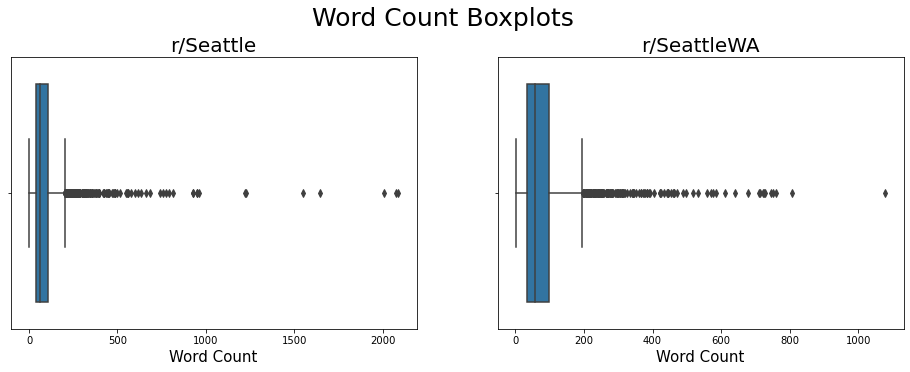

In [26]:
fig, axes = plt.subplots(1,2, figsize = (16,5))

fig.suptitle('Word Count Boxplots', size = 25, y = 1.02)
sns.boxplot(x = sea['word_count'], ax = axes[0])
axes[0].set_title('r/Seattle', size = 20)
axes[0].set_xlabel('Word Count', size = 15)

sns.boxplot(x = sea_wa['word_count'], ax = axes[1])
axes[1].set_title('r/SeattleWA', size = 20)
axes[1].set_xlabel('Word Count', size = 15);

In [27]:
sea['word_count'].describe()

count    2492.000000
mean       93.412119
std       127.173531
min         0.000000
25%        39.000000
50%        62.000000
75%       104.250000
max      2088.000000
Name: word_count, dtype: float64

There are several extraordinarily long posts in r/Seattle and at least one longer post in r/Seattle. Let us print the contents of these post to see if they make sense to remove from our datasets.

In [28]:
for entry in sea.loc[sea['word_count'] > 1500, 'text']:
    print(entry)
    print('-------\n')

seattl citi council newslett reddit: hey everyon i want introduc my name georg i rise junior stanford interest civic engag polit i start work project student that’ total awesom cool basic we’v made newslett summar info seattl citi council meet access easi way i put exampl week though real thing bit format translat reddit thi project new would realli appreci feedback may i would love see comment show i need make newslett best i total recommend join who doesn’t want know goe behind scene beauti citi if interest receiv weekli email inbox click link: exampl newsletter: seattl citi council meet summari - week septemb 12 2022 council brief 9 12 meet length - 1:32:07 all councilmemb present council meet 9 13 meet length - 1:19:32 all councilmemb present present ami gore member citi council central staff share brief regard seattl initi 135 establish seattl social hous develop new public develop author social hous develop maintain publicli financ mixed-incom social hous develop the initi creat 

The only posts that immediately seem worthwhile dropping from r/Seattle are the City Council Newsletter post (the first entry above) and the post referring to Uvalde police (the second and third post above).

The City Council post seems to contain very specialized vocabulary and is lengthy by the nature of the post. These posts also seem regular though, so it would be out of place to drop just this especially lengthy post and not the other posts. Dropping all City Council posts by this person seems a bit excessive, so we will leave the City Council posts in.

There are two posts about Uvalde police. They appear to be identical except for some select words and some repeated characters that are used to distinguish the heading and body. I am sure there are more posts that are slightly off from being identical. We cannot remove them all, but since we stumbled upon this pair, we may as well remove one of them.

In [29]:
print(sea[sea['text'].str.contains('SPD should be barred from')].index)
sea.drop(index = 542, inplace = True)

Int64Index([], dtype='int64')


In [30]:
for entry in sea_wa.loc[sea_wa['word_count'] > 1000, 'text']:
    print(entry)
    print('-------\n')

use afford hous get the properti ladder seattl the median home price seattl $934k a year back i decid settl buy hous i come $200k payment i use fairli convolut method deal someon forum ask elabor i i thought i'd make post when start date look place realli farther seattl ideal even place lynnwood stretch budget we conundrum felt like option nightmarish commut everett rent indefinit when median home price seattl $449k $182k la vega so bought place rent home cheap one problem get financ not qualifi but loan small bank want i learn bank basic loan home balanc $100k i know peopl think 15% year-over-year increas home price seem like lot seattl portland san francisco lo angel way back pack come stuff for instanc vega 305% last year the way make money real estat realli basic: can borrow money lower rate properti go if ye make money for instanc 2020 could borrow 3% so invest million real estat vega 2021 $305k today would spent $30000 borrow money leav profit $275k 2006 could borrow 6% so invest

Nothing about the lengthiest post in r/SeattleWA suggests it needs to be removed. Let us leave it in.

Next let us look for posts that are too short to reasonably use.

In [31]:
sea.loc[sea['word_count'] < 10, 'text']

400                           the west seattl bridg open
423                  what’ fighter jet south seattl titl
435                                how seattl chang year
757     anyon recommend good dental insur compani titl ^
768                                earthquak around 1:08
805                               hi all anyon kiingston
1191                                                    
1292                                          weapon pet
1346               employ discrimin lawyer ani recommend
1422                                yo seattl area 🔌 hmu
1425                    where’ best quesadilla town titl
1748                              hey guy i want say hey
1755                        how’ comedi scene need laugh
1766        seattl pass protect abort gender affirm care
1775             best junkyard pull part recommend thank
1782                              it’ thunder move along
1838                                      it' rain that'
2277                           

The only post that obviously should be removed is the empty one at index 1191.

In [32]:
sea.drop(index = 1191, inplace = True)

For r/SeattleWA we can already see a pretty big difference below in the number of posts with fewer than 10 words and their content compared to r/Seattle. No posts here seem to require being dropped. Even the shorter posts convey a fair bit of sentiment.

There are:
- four posts about shootings (5, 6, 104, 2349)
- two posts are about urine (38, 1494) 
- one Pepe Silvia post - a meme about conspiracy theories (323)
- one post about being woke (1594)
- several sarcastic or contextually negative posts (235, 322, 430)

In [33]:
sea_wa.loc[sea_wa['word_count'] < 10, 'text']

5           shoot near pioneer squar around 3:30 pm today
6                                     shoot pioneer squar
38                 will piss mania come seattl piss mania
104                                         anoth 1 shoot
110                        who' beauti person seen seattl
142                        insle end covid-19 state emerg
149     what consid greater seattl what’ consid greate...
194                                               moder i
235                        yup great mind come next gener
322                                                  iron
323                                           pepe silvia
373                         saxophon anyon teach saxophon
389                 idea happen process img 837t87mh0ii91
403                           realiz put color book train
430                                           bye felicia
607          ani breakfast recommend eastsid thank advanc
612                            is seattle' signatur scent
749           

Even when we examine an expanded the list of short posts from r/Seattle, the sentiment still differs from r/SeattleWA.

In [34]:
sea.loc[sea['word_count'] < 15, 'text']

96      anyon els current drunk run problem what bar w...
140     recommend nice sit-down lunch spot u district ...
176          traffic-geddon 9 23 what hell happen tonight
323               best al pastor taco area and use trompo
400                            the west seattl bridg open
423                   what’ fighter jet south seattl titl
435                                 how seattl chang year
436                 which like better seattl vancouv bc …
507                      can i sell u cigarett i ask 2 1$
538      anyon insight fun thing downtown christma season
623               box where’ best bar pub watch box match
660     'make good progress negotiations' seattl schoo...
757      anyon recommend good dental insur compani titl ^
768                                 earthquak around 1:08
775        car explod next i5 process video nm5zpck03km91
805                                hi all anyon kiingston
929     best breakfast burrito seattl what’ favorit br...
978     doe an

Even if we are lax about identifying negative posts, the posts in r/Seattle just seem less surly than r/SeattleWA. Below are posts that might be viewed as negative:
- explosions or booms (775, 1845, 2235)
- weaponizing your pets (1292)
- employment discrimination lawyer (1346)
- what in the world is going on (2032)
- shooting (2089)
- stay away from this person (2337)

#### Basic Visuals

We saw earlier from boxplots that r/seattle has more posts with very high word counts. Let us compare the distribution of posts with word counts below 1000.

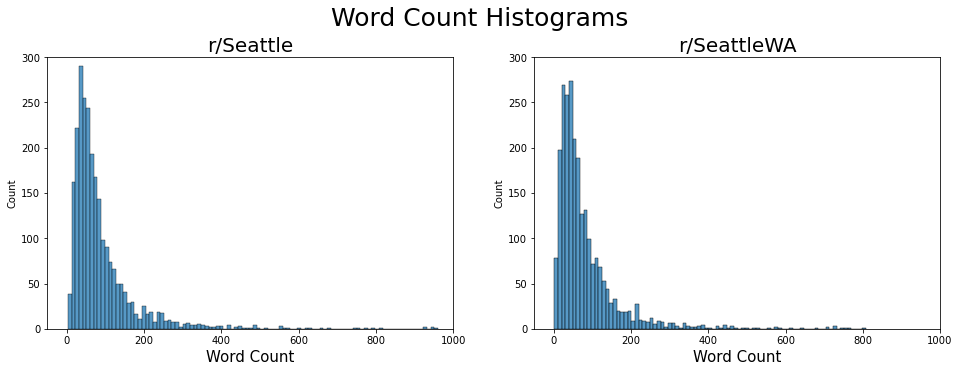

In [35]:
fig, axes = plt.subplots(1,2, figsize = (16,5))

sea_sub_1000 = sea[sea['word_count'] < 1000]
sea_wa_sub_1000 = sea_wa[sea_wa['word_count'] < 1000]

fig.suptitle('Word Count Histograms', size = 25, y = 1.02)
sns.histplot(x = sea_sub_1000['word_count'], ax = axes[0])
axes[0].set_title('r/Seattle', size = 20)
axes[0].set_xlabel('Word Count', size = 15)
axes[0].set_xlim(-50, 1000)
axes[0].set_ylim(-0, 300)

sns.histplot(x = sea_wa_sub_1000['word_count'], ax = axes[1])
axes[1].set_title('r/SeattleWA', size = 20)
axes[1].set_xlabel('Word Count', size = 15)
axes[1].set_xlim(-50, 1000)
axes[1].set_ylim(-0, 300);

The histogram shapes are nearly identical between the two subreddits. There may be slightly less volume on the left side of the r/SeattleWA histogram, but it is hard to say.

Next we look at the distributions of sentiment scores.

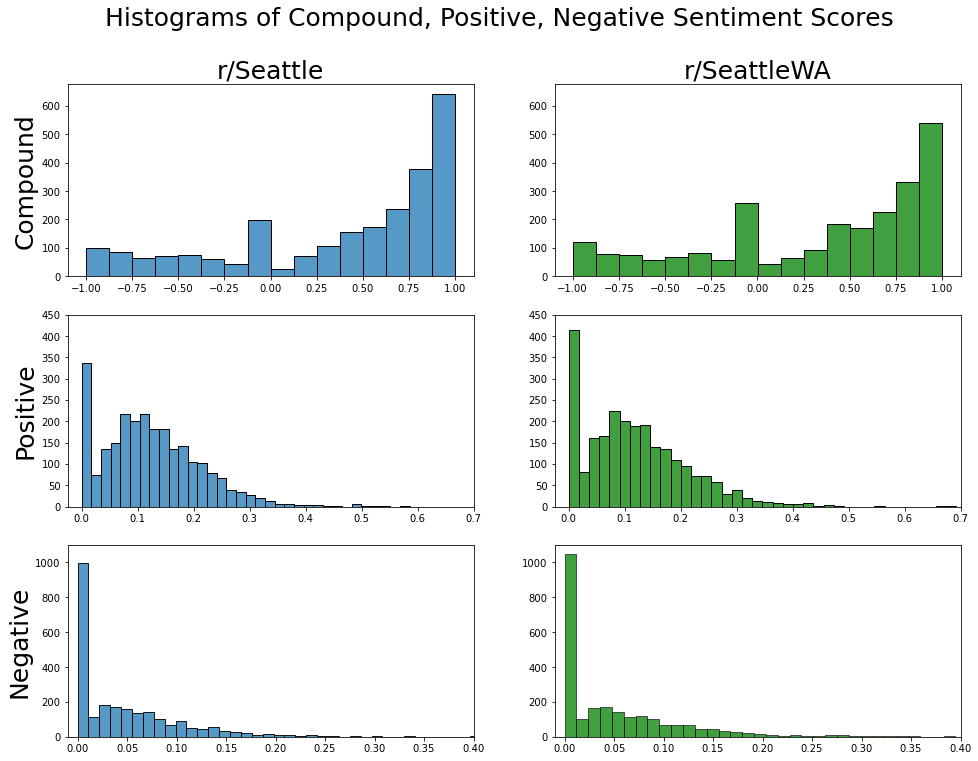

In [36]:
#from matplotlib.lines import Line2D

fig, axes = plt.subplots(3,2, figsize = (16,12))

fig.suptitle('Histograms of Compound, Positive, Negative Sentiment Scores', size = 25, y = 0.97)

#---------------------------
# r/Seattle sentiment scores
#---------------------------
sns.histplot(x = sea['sent_compound'], ax = axes[0,0])
axes[0,0].set_title('r/Seattle', size = 25)
axes[0,0].set_xlabel('', size = 15)
axes[0,0].set_ylabel('Compound', size = 25)
axes[0,0].set_ylim(0, 675)

sns.histplot(x = sea['sent_pos'], ax = axes[1,0])
#axes[1,0].set_title('Positive', size = 20)
axes[1,0].set_xlabel('', size = 15)
axes[1,0].set_ylabel('Positive', size = 25)
axes[1,0].set_xlim(-0.025, 0.7)
axes[1,0].set_ylim(0, 450)

sns.histplot(x = sea['sent_neg'], ax = axes[2,0])
#axes[2,0].set_title('Negative', size = 20)
axes[2,0].set_xlabel('', size = 15)
axes[2,0].set_ylabel('Negative', size = 25)
axes[2,0].set_xlim(-0.01, 0.4)
axes[2,0].set_ylim(0, 1100)


#-------------------------------
# # r/SeattleWA sentiment scores
#-------------------------------
sns.histplot(x = sea_wa['sent_compound'], ax = axes[0,1], color = 'green')
axes[0,1].set_title('r/SeattleWA', size = 25)
axes[0,1].set_xlabel('', size = 15)
axes[0,1].set_ylabel('', size = 15)
axes[0,1].set_ylim(0, 675)

sns.histplot(x = sea_wa['sent_pos'], ax = axes[1,1], color = 'green')
#axes[1,1].set_title('r/Seattle', size = 20)
axes[1,1].set_xlabel('', size = 15)
axes[1,1].set_ylabel('', size = 15)
axes[1,1].set_xlim(-0.025, 0.7)
axes[1,1].set_ylim(0, 450)

sns.histplot(x = sea_wa['sent_neg'], ax = axes[2,1], color = 'green')
#axes[1,2].set_title('r/Seattle', size = 20)
axes[2,1].set_xlabel('', size = 15)
axes[2,1].set_ylabel('', size = 15)
axes[2,1].set_xlim(-0.01, 0.4)
axes[2,1].set_ylim(0, 1100);

# custom legend
# legend_elements = [Line2D([0], [0], color='tab:blue', lw=4, label='r/Seattle'), 
#                    Line2D([0], [0], color='tab:green', lw=4, label='r/SeattleWA'),]

# legend = axes[2,1].legend(handles = legend_elements, fontsize = 20);

The above plots show that the sentiment scores between r/Seattle and r/SeattleWA look very similar. The most notable differences are:
- the highest compound scores appear more frequently in r/Seattle
- the lowest positive scores appear more frequently in r/SeattleWA
- the higher negative scores appear slightly more frequently in r/SeattleWA

The first bullet on compound scores stands out the most and agrees with the first impressions of each subreddit. The second bullet also aligns with our impressions, but the rest of the positive sentiment histograms (outside of the leftmost bar) do not illustrate any differences between the two subreddits. The last bullet is hardly notable at all.

In [37]:
sea.to_csv('datasets/Cleaned_Seattle.csv', index = False)
sea_wa.to_csv('datasets/Cleaned_SeattleWA.csv', index = False)